In [232]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.datasets import make_classification, make_moons
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from IPython.display import display, Markdown
from sklearn.dummy import DummyClassifier
from scipy.stats.mstats import winsorize
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings


In [233]:
warnings.filterwarnings('ignore', category=UserWarning)

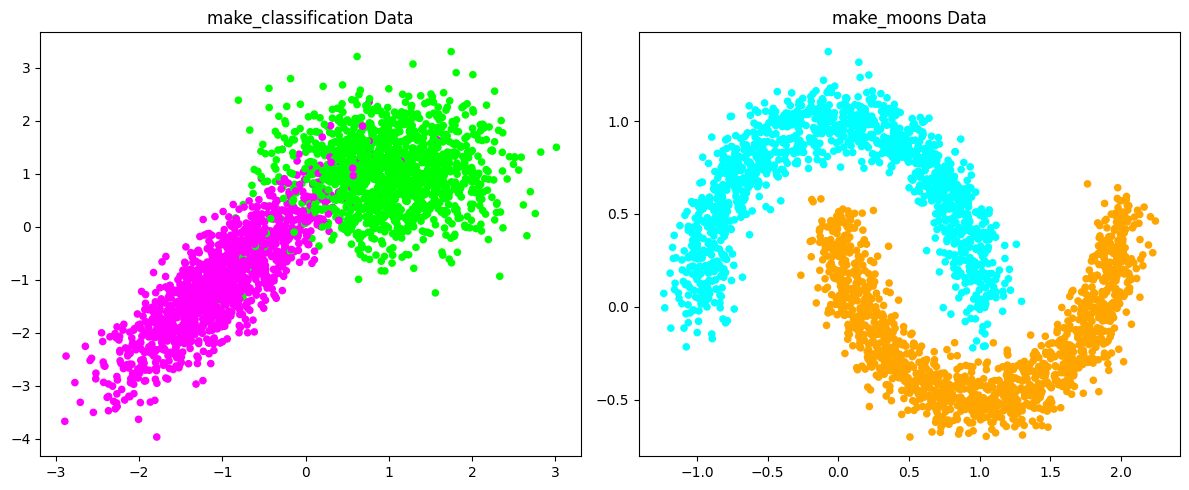

In [234]:
random_state=254493
n_samples = 2593

X_clf, t_clf = make_classification(random_state=random_state, n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

X_moons, t_moons = make_moons(random_state=random_state, n_samples=n_samples, noise=0.1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_clf[:, 0], X_clf[:, 1], c=np.where(t_clf==0, 'lime', 'magenta'), s=20)
plt.title('make_classification Data')

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=np.where(t_moons==0, 'cyan', 'orange'), s=20)
plt.title('make_moons Data')

plt.tight_layout()
plt.show()

In [235]:
X_train_clf, X_test_clf, t_train_clf, t_test_clf = train_test_split(X_clf, t_clf, test_size=0.2, random_state=random_state)
X_train_moons, X_test_moons, t_train_moons, t_test_moons = train_test_split(X_moons, t_moons, test_size=0.2, random_state=random_state)

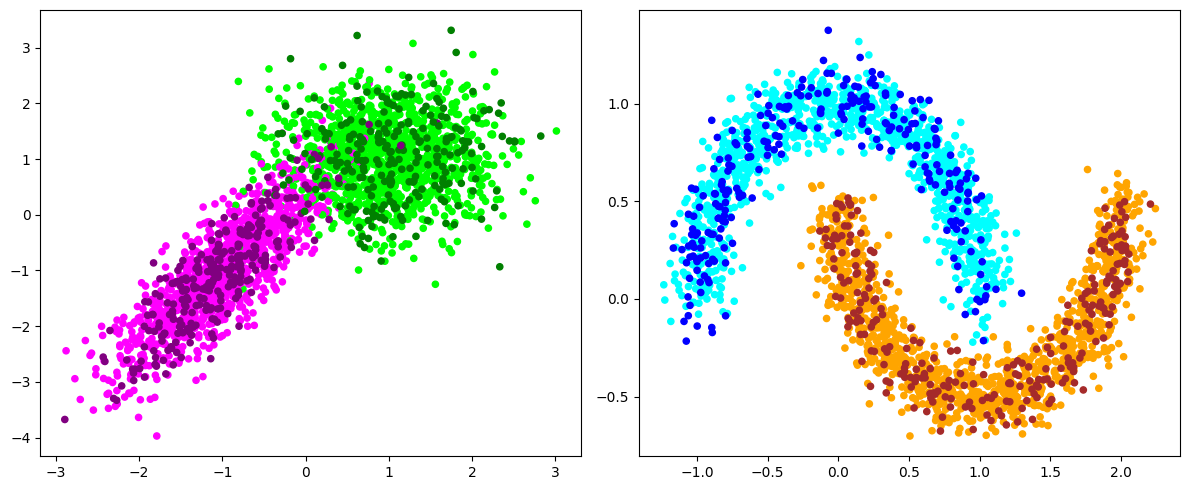

In [236]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_clf[:, 0], X_train_clf[:, 1], c=np.where(t_train_clf==0, 'lime', 'magenta'), s=20)
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1], c=np.where(t_test_clf==0, 'green', 'purple'), s=20)


plt.subplot(1, 2, 2)
plt.scatter(X_train_moons[:, 0], X_train_moons[:, 1], c=np.where(t_train_moons==0, 'cyan', 'orange'), s=20)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=np.where(t_test_moons==0, 'blue', 'brown'), s=20)

plt.tight_layout()
plt.show()


In [237]:
def sigmoid(x, beta=1.0):
    return 1 / (1 + np.exp(-beta * x))

def logistic_regression(X, t, eta=0.1, beta=1.0, iterations=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    
    for _ in range(iterations):
        for j in range(n_samples):
            y = sigmoid(np.dot(X[j], w), beta)
            error = t[j] - y
            gradient = -eta * error * y * (1 - y) * X[j]
            w -= gradient

    return w

weights = logistic_regression(X_train_clf, t_train_clf)
t_pred = sigmoid(np.dot(X_test_clf, weights)) > 0.5
accuracy = accuracy_score(t_test_clf, t_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9672447013487476


In [238]:
def plot_metrics_and_roc(X_test, y_test, weights):
    y_pred_proba = sigmoid(np.dot(X_test, weights))
    y_pred_test = y_pred_proba > 0.5
    y_pred_test = y_pred_test.astype(int)  # Konwersja True/False na 1/0
    
    cm = confusion_matrix(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    sensitivity = recall_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    TN = cm[0][0]
    FP = cm[0][1]
    specificity = TN / (TN + FP)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    ax1.set_title(f'Confusion Matrix\nAccuracy={accuracy:.4f}, Sensitivity={sensitivity:.4f},\n Precision={precision:.4f}, Specificity={specificity:.4f}')
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')

    ax2.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.fill_between(fpr, tpr, color='skyblue', alpha=0.5)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

In [239]:
def plot_decision_boundary( X_test, t_test, weights, title, colours, beta=1.0, resolution=100):

    margin_x = 0.1 * (X_test[:, 0].max() - X_test[:, 0].min())
    margin_y = 0.1 * (X_test[:, 1].max() - X_test[:, 1].min())
    x_min, x_max = X_test[:, 0].min() - margin_x, X_test[:, 0].max() + margin_x
    y_min, y_max = X_test[:, 1].min() - margin_y, X_test[:, 1].max() + margin_y

  
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sigmoid(np.dot(grid, weights), beta).reshape(xx.shape)

    
    colors = [colours[0], colours[1]]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
    
 
    plt.figure(figsize=(8, 6))  
    plt.contourf(xx, yy, probs, alpha=0.2, levels=np.linspace(0, 1, 50), cmap=cmap)
    plt.colorbar()

    t_pred_test = sigmoid(np.dot(X_test, weights)) > 0.5
    misclassified = t_pred_test != t_test
    plt.scatter(X_test[:, 0], X_test[:, 1], c=t_test, edgecolors='none', cmap=cmap)
    plt.scatter(X_test[misclassified, 0], X_test[misclassified, 1], edgecolors='blue', facecolors='none', s=50) 
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()


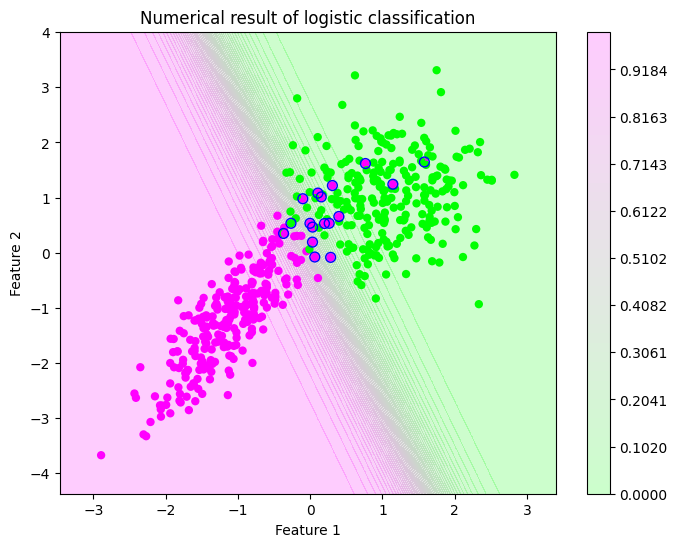

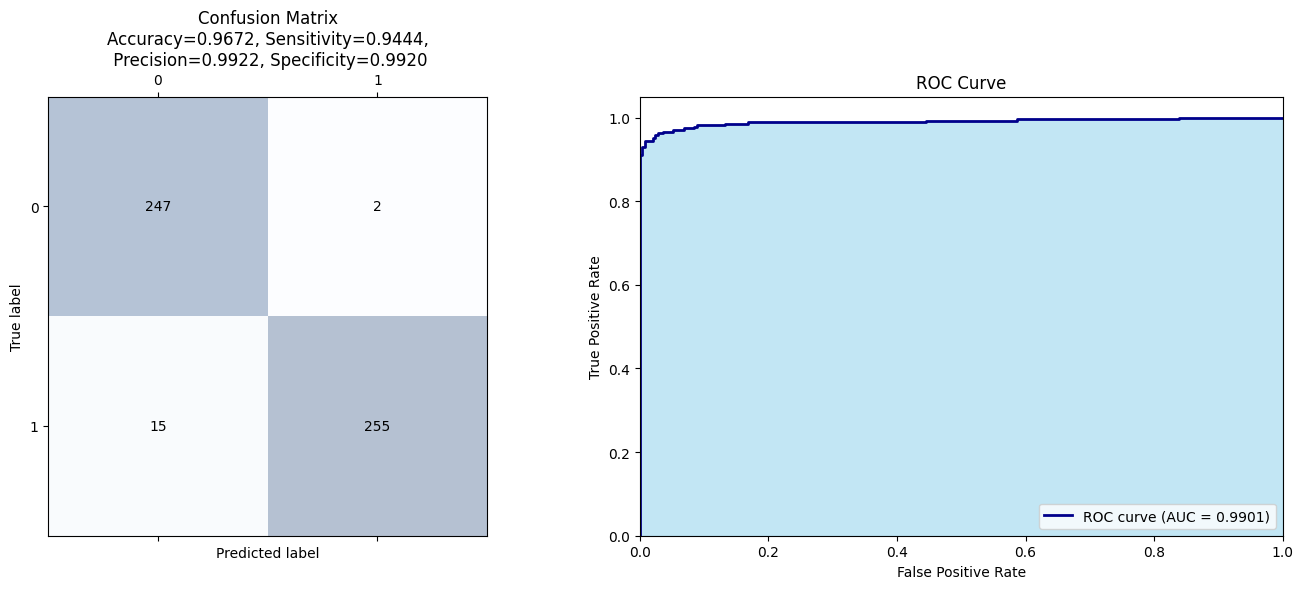

In [240]:
plot_decision_boundary(X_test_clf, t_test_clf, weights,'Numerical result of logistic classification', ['lime', 'magenta'])
plot_metrics_and_roc(X_test_clf, t_test_clf, weights)

In [241]:
weights = logistic_regression(X_train_moons, t_train_moons)
t_pred = sigmoid(np.dot(X_test_moons, weights)) > 0.5
accuracy = accuracy_score(t_test_moons, t_pred)
print("Accuracy:", accuracy)

Accuracy: 0.882466281310212


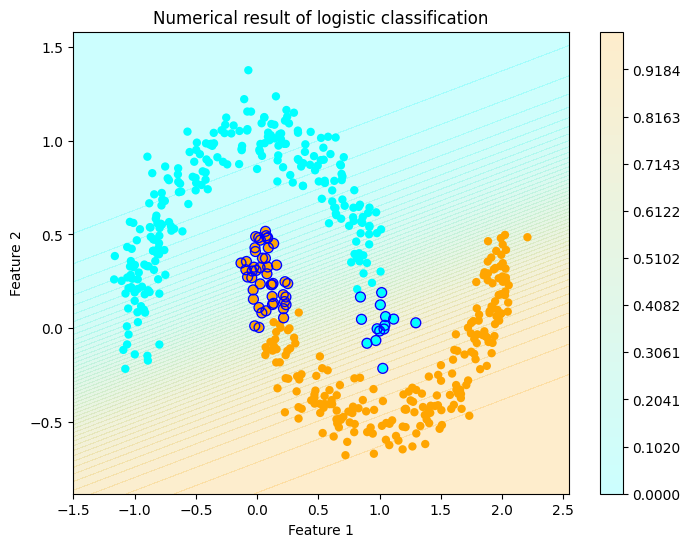

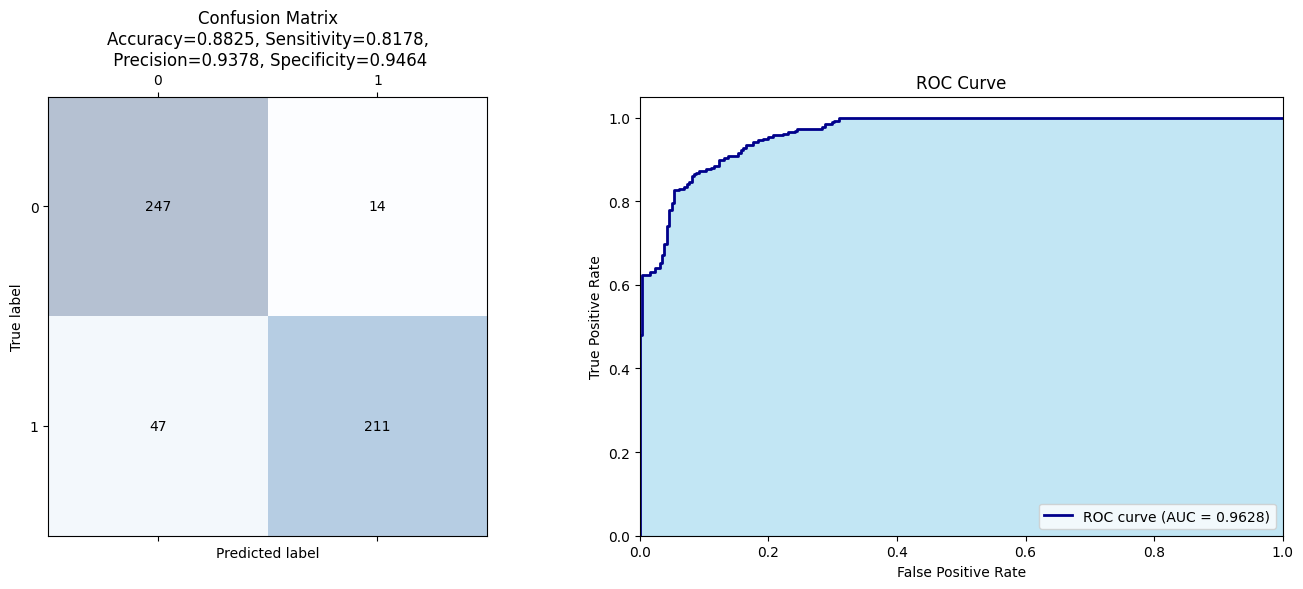

In [242]:
plot_decision_boundary( X_test_moons, t_test_moons, weights, 'Numerical result of logistic classification', ['cyan', 'orange'])
plot_metrics_and_roc(X_test_moons, t_test_moons, weights)

In [243]:
clf = LogisticRegression(random_state=random_state)
clf.fit(X_train_clf, t_train_clf)
clf.predict(X_test_clf)
weights = clf.coef_[0]
accuracy = clf.score(X_test_clf, t_test_clf)

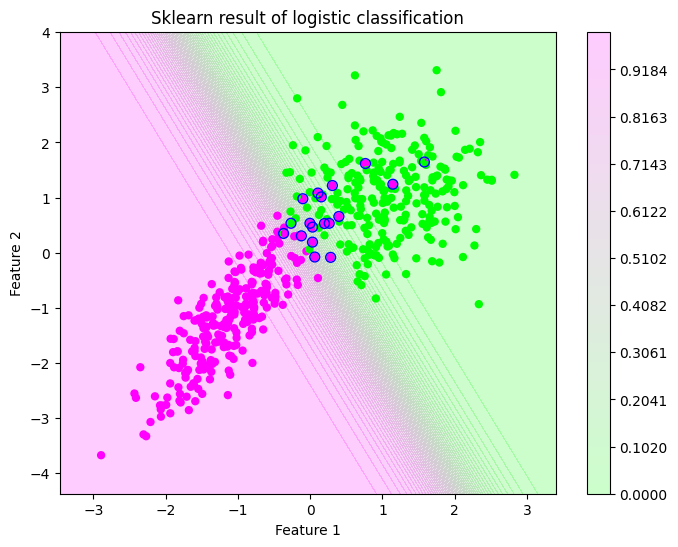

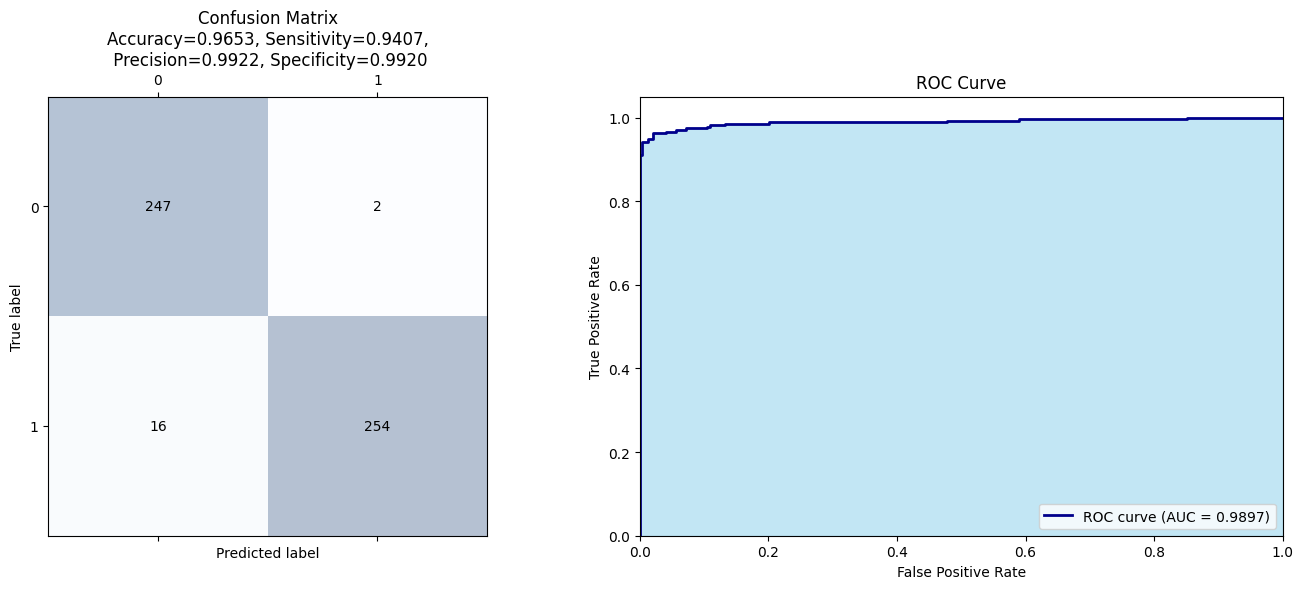

In [244]:
plot_decision_boundary(X_test_clf, t_test_clf, weights,'Sklearn result of logistic classification', ['lime', 'magenta'])
plot_metrics_and_roc(X_test_clf, t_test_clf, weights)

In [245]:
clf.fit(X_train_moons, t_train_moons)
clf.predict(X_test_moons)
weights = clf.coef_[0]
accuracy = clf.score(X_test_moons, t_test_moons)

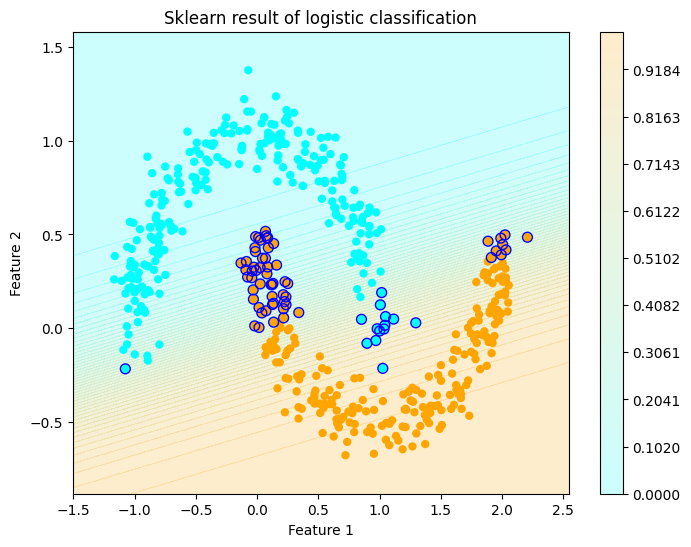

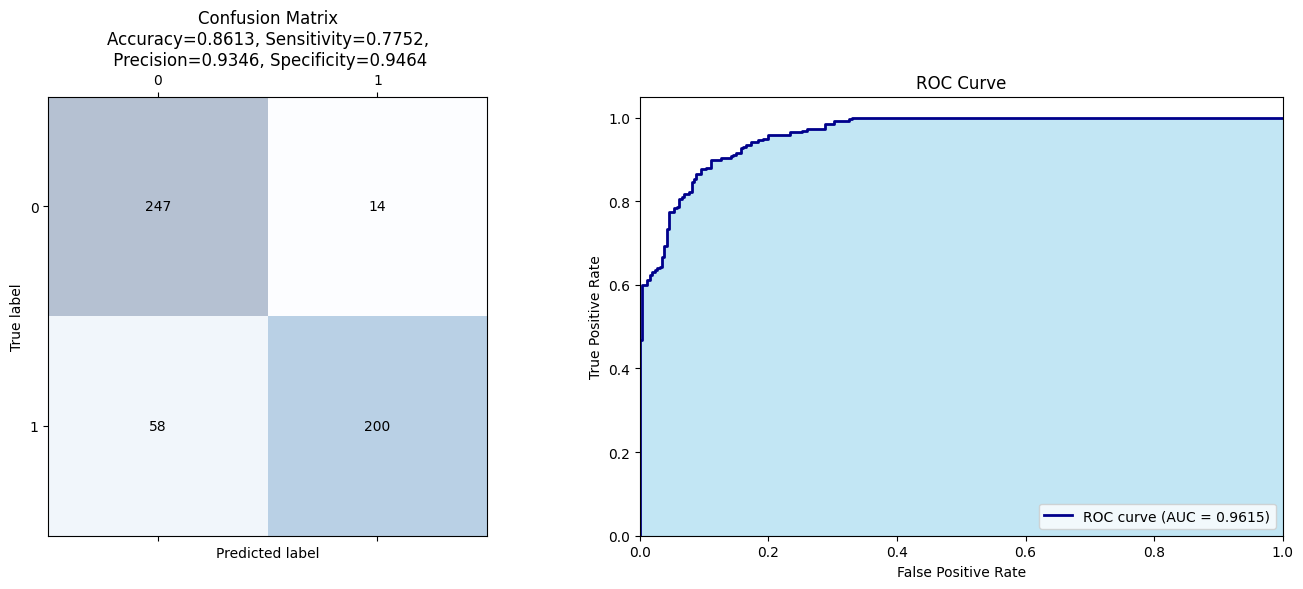

In [246]:
plot_decision_boundary(X_test_moons, t_test_moons, weights,'Sklearn result of logistic classification', ['cyan', 'orange'])
plot_metrics_and_roc(X_test_moons, t_test_moons, weights)

Rain in Australia

In [247]:
data = pd.read_csv('rainAUS.csv')
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Usuń kolumny mające więcej in 30% brakujących wartości

In [248]:
threshold = 0.7 * len(data)
print(threshold)
data.dropna(thresh=threshold, axis=1, inplace=True)

101822.0


Dokonaj imputacji brakujących wartości zakładając że są one MCAR (Missing Completely At Random) - zmienne kategoryczne należy zastąpić dominantą a dane numeryczne medianą.

In [249]:
data.replace('?', pd.NA, inplace=True)

In [250]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)

In [251]:
numerical_cols = data.select_dtypes(include=['float64', 'int64'])

Dokonaj winsoryzacji danych odstających ponad 1.5 IQR.

In [252]:
stats_df_before_winsorizing = pd.DataFrame()
for col in numerical_cols:
    stats_df_before_winsorizing[col] = data[col].describe()
stats_df_before_winsorizing = stats_df_before_winsorizing.T
stats_df_before_winsorizing


,count,mean,std,min,25%,50%,75%,max
MinTemp,145460.0,12.192053,6.365780,-8.5,7.7,12.0,16.8,33.9
MaxTemp,145460.0,23.215962,7.088358,-4.8,18.0,22.6,28.2,48.1
Rainfall,145460.0,2.307990,8.389771,0.0,0.0,0.0,0.6,371.0
WindGustSpeed,145460.0,39.962189,13.120931,6.0,31.0,39.0,46.0,135.0
WindSpeed9am,145460.0,14.030751,8.861796,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,145460.0,18.669758,8.716716,0.0,13.0,19.0,24.0,87.0
Humidity9am,145460.0,68.901251,18.855360,0.0,57.0,70.0,83.0,100.0
Humidity3pm,145460.0,51.553396,20.471345,0.0,37.0,52.0,65.0,100.0
Pressure9am,145460.0,1017.644768,6.728484,980.5,1013.5,1017.6,1021.8,1041.0
Pressure3pm,145460.0,1015.250115,6.663994,977.1,1011.1,1015.2,1019.4,1039.6


In [253]:
for col in numerical_cols.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    lower_limit = (data[col] < lower_bound).mean()
    upper_limit = (data[col] > upper_bound).mean()
    
    data[col] = winsorize(data[col], limits=(lower_limit, upper_limit))

In [254]:
stats_df_after_winsorizing= pd.DataFrame()
for col in numerical_cols:
    stats_df_after_winsorizing[col] = data[col].describe()
stats_df_after_winsorizing = stats_df_after_winsorizing.T
stats_df_after_winsorizing

,count,mean,std,min,25%,50%,75%,max
MinTemp,145460.0,12.192349,6.364397,-5.9,7.7,12.0,16.8,30.3
MaxTemp,145460.0,23.219758,7.067804,2.7,18.0,22.6,28.2,43.5
Rainfall,145460.0,0.381674,0.608638,0.0,0.0,0.0,0.6,1.5
WindGustSpeed,145460.0,39.586601,12.043892,9.0,31.0,39.0,46.0,67.0
WindSpeed9am,145460.0,13.939757,8.555976,0.0,7.0,13.0,19.0,37.0
WindSpeed3pm,145460.0,18.557108,8.376878,0.0,13.0,19.0,24.0,39.0
Humidity9am,145460.0,68.953025,18.704151,18.0,57.0,70.0,83.0,100.0
Humidity3pm,145460.0,51.553396,20.471345,0.0,37.0,52.0,65.0,100.0
Pressure9am,145460.0,1017.671853,6.566076,1001.1,1013.5,1017.6,1021.8,1034.2
Pressure3pm,145460.0,1015.268598,6.526706,998.7,1011.1,1015.2,1019.4,1031.8


Podziel dane dla
każdego z regionów na zbiory testowe i treningowe ze stratyfikacją.

In [255]:
X = data.iloc[:, :-1] 
y = data.iloc[:, -1]  

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Znormalizuj dane numeryczne
i zakoduj (one-hot) dane kategoryczne.

In [257]:
scaler = StandardScaler()
X_train[numerical_cols.columns] = scaler.fit_transform(X_train[numerical_cols.columns])
X_test[numerical_cols.columns] = scaler.transform(X_test[numerical_cols.columns])

In [258]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object' and col != 'Location' and col != 'Date']

encoder = OneHotEncoder(sparse=False, drop='first')

X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

X_train_prepared = pd.concat([X_train[numerical_cols.columns], X_train_encoded_df], axis=1)
X_test_prepared = pd.concat([X_test[numerical_cols.columns], X_test_encoded_df], axis=1)

c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Należy zwrócić szczególną uwagę na cykliczny charakter
komponentów w daty - data jest dyskretną numeryczną wartością złożoną.

In [259]:
def encode_cyclic_features(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column])
    
    data['day_sin'] = np.sin(2 * np.pi * data[date_column].dt.day/31)
    data['day_cos'] = np.cos(2 * np.pi * data[date_column].dt.day/31)
    
    data['month_sin'] = np.sin(2 * np.pi * data[date_column].dt.month/12)
    data['month_cos'] = np.cos(2 * np.pi * data[date_column].dt.month/12)

    return data

In [260]:
X_train = encode_cyclic_features(X_train, 'Date')
X_test = encode_cyclic_features(X_test, 'Date')

In [261]:
X_train_prepared = pd.concat([X_train[numerical_cols.columns], X_train_encoded_df, X_train[['day_sin', 'day_cos', 'month_sin', 'month_cos']]], axis=1)
X_test_prepared = pd.concat([X_test[numerical_cols.columns], X_test_encoded_df, X_test[['day_sin', 'day_cos', 'month_sin', 'month_cos']]], axis=1)
X_train_prepared['Location'] = X_train['Location']
X_test_prepared['Location'] = X_test['Location']


In [262]:
X_train_prepared

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,day_sin,day_cos,month_sin,month_cos,Location
27555,0.957698,0.293099,-0.628433,-0.050450,-1.394998,-1.978727,0.751483,0.510620,-0.117040,-0.163675,...,0.0,0.0,0.0,0.0,0.0,-9.884683e-01,0.151428,0.500000,8.660254e-01,Richmond
83553,-0.189099,-0.823501,-0.628433,-1.130735,-0.811165,-0.665381,1.018839,0.266270,0.812317,1.016024,...,0.0,0.0,0.0,0.0,0.0,-3.943559e-01,0.918958,1.000000,6.123234e-17,Dartmoor
145028,1.036245,1.197687,-0.628433,-0.715241,0.356501,0.050990,-1.333887,-1.346439,-0.162746,-0.224958,...,0.0,0.0,0.0,0.0,0.0,-7.907757e-01,-0.612106,0.866025,-5.000000e-01,Uluru
78396,0.957698,-0.173329,1.831526,0.115748,-0.344099,0.050990,1.553549,0.803840,-0.985456,-0.439449,...,0.0,0.0,0.0,0.0,1.0,6.513725e-01,-0.758758,0.866025,5.000000e-01,Watsonia
70789,0.973407,1.960932,-0.300439,-0.050450,0.940334,0.050990,-1.868597,-1.248699,-0.010393,-0.853110,...,0.0,0.0,0.0,0.0,0.0,2.012985e-01,0.979530,0.866025,5.000000e-01,Mildura
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20058,-0.094841,0.038684,-0.628433,0.697440,2.458300,0.409175,-0.906119,-1.053219,-0.360806,-0.960355,...,0.0,0.0,0.0,0.0,0.0,-2.449294e-16,1.000000,-0.500000,-8.660254e-01,NorahHead
112876,-0.393323,-0.781098,0.355551,-1.296933,-0.811165,-0.665381,0.056360,0.021920,1.421732,1.475647,...,0.0,0.0,1.0,0.0,0.0,-6.513725e-01,-0.758758,-0.500000,-8.660254e-01,Witchcliffe
56517,-1.367314,-1.106185,-0.628433,-0.798340,0.356501,-0.426591,0.163302,0.803840,-0.315100,-0.041109,...,0.0,0.0,0.0,0.0,0.0,1.011683e-01,-0.994869,-0.500000,8.660254e-01,Ballarat
94207,0.847731,0.307233,0.355551,0.115748,-0.577632,0.170385,-0.157524,0.754970,0.309550,0.249985,...,0.0,0.0,0.0,0.0,0.0,-1.011683e-01,-0.994869,-0.500000,-8.660254e-01,Townsville


# Naucz osobny model LogisticRegression() dla każdego z regionów.

In [263]:
models = {}
accuracy_scores = defaultdict(dict)

for location in X_train_prepared['Location'].unique():

    train_mask = X_train_prepared['Location'] == location
    test_mask = X_test_prepared['Location'] == location


    X_train_loc = X_train_prepared[train_mask].drop('Location', axis=1)
    y_train_loc = y_train[train_mask]
    X_test_loc = X_test_prepared[test_mask].drop('Location', axis=1)
    y_test_loc = y_test[test_mask]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_loc, y_train_loc)
    models[location] = model

    y_pred_loc = model.predict(X_test_loc)
    accuracy = accuracy_score(y_test_loc, y_pred_loc)
    accuracy_scores[location] = accuracy
    # print(f"Accuracy dla {location}: {accuracy:.2f}")

top5_locations = sorted(accuracy_scores, key=accuracy_scores.get, reverse=True)[:5]
for location in top5_locations:
    print('Accuracy dla ', location, ': ', accuracy_scores[location])
best_location_for_regional_prediction = top5_locations[0]

Accuracy dla  Uluru :  0.9424242424242424
Accuracy dla  AliceSprings :  0.9418604651162791
Accuracy dla  Mildura :  0.9348171701112877
Accuracy dla  Woomera :  0.931438127090301
Accuracy dla  Cobar :  0.9246575342465754


In [264]:
def plot_metrics_and_roc_adjusted(X_test, y_test, model, location):
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] 
    cm = confusion_matrix(y_test, y_pred_test, labels=['No', 'Yes'])
    accuracy = accuracy_score(y_test, y_pred_test)
    sensitivity = recall_score(y_test, y_pred_test, pos_label='Yes')
    precision = precision_score(y_test, y_pred_test, pos_label='Yes')
    TN = cm[0][0]
    FP = cm[0][1]
    specificity = TN / (TN + FP)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba_test, pos_label='Yes')
    roc_auc = auc(fpr, tpr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    ax1.set_title('Confusion Matrix for {} \nAccuracy={:.4f}, Sensitivity={:.4f},\n Precision={:.4f}, Specificity={:.4f}'.format(location, accuracy, sensitivity, precision, specificity))
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')

    ax2.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
    ax2.fill_between(fpr, tpr, color='skyblue', alpha=0.5)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Który model ma najwyższą skuteczność?

Wyniki modelu dla Uluru:


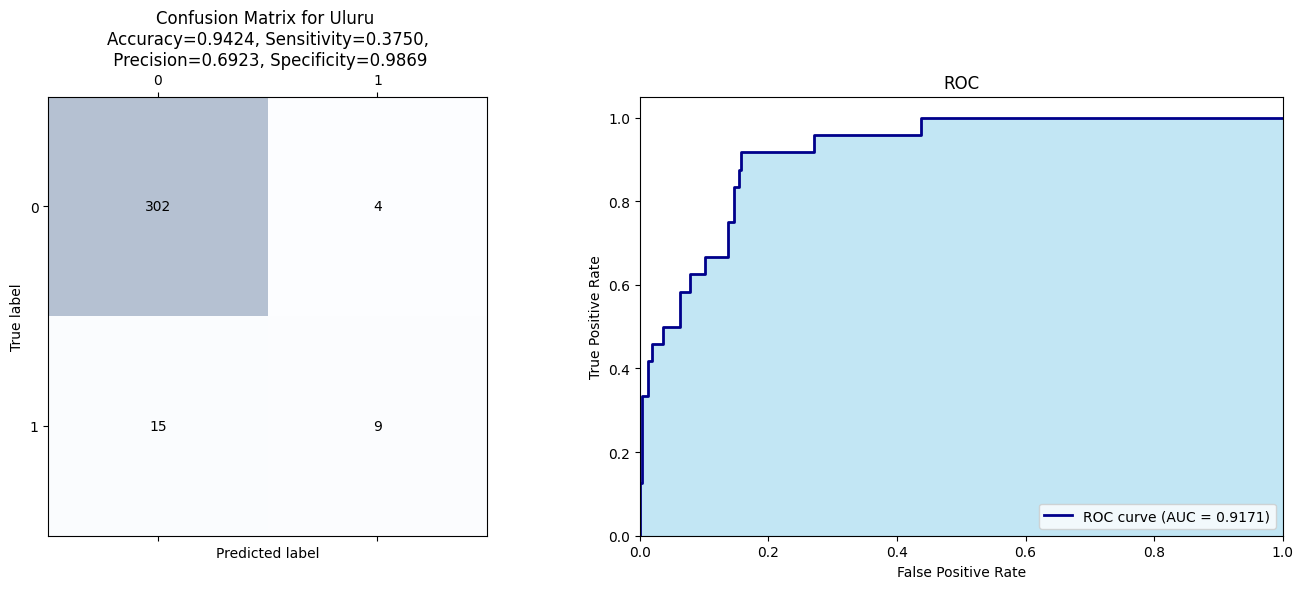

Wyniki modelu dla AliceSprings:


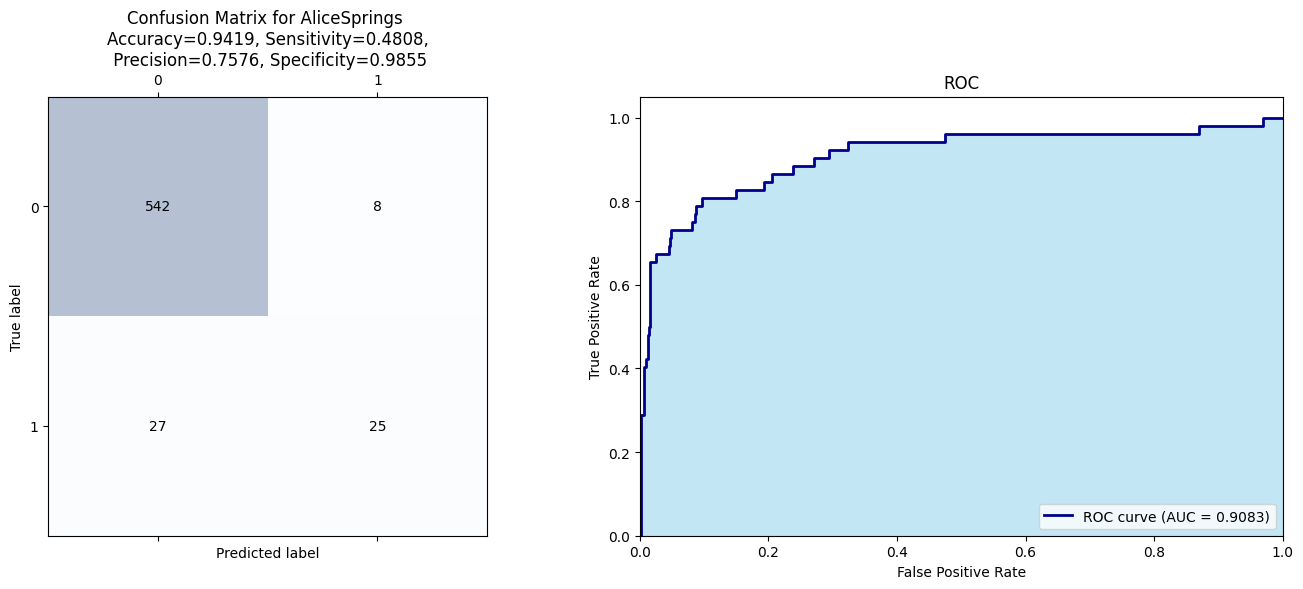

Wyniki modelu dla Mildura:


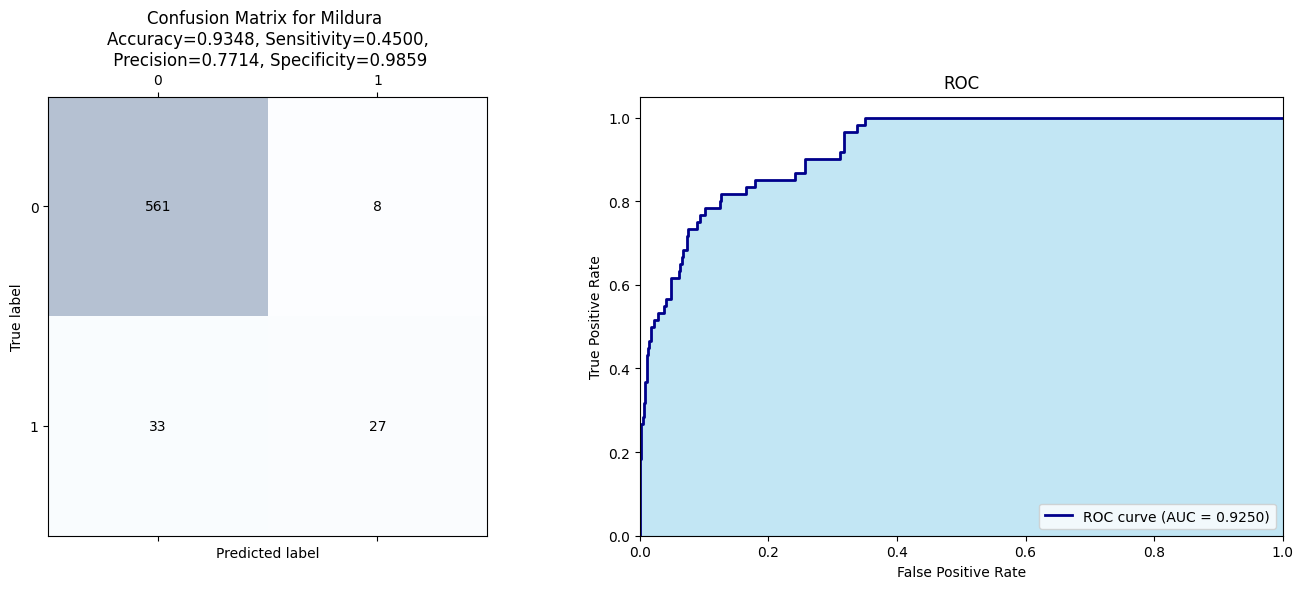

Wyniki modelu dla Woomera:


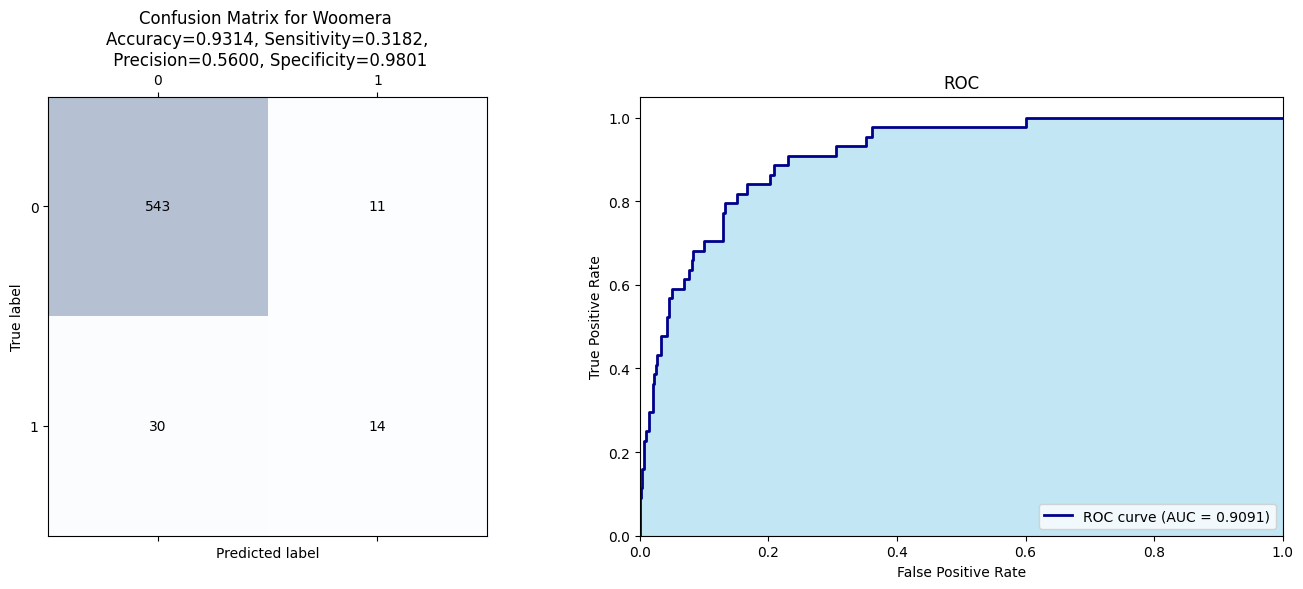

Wyniki modelu dla Cobar:


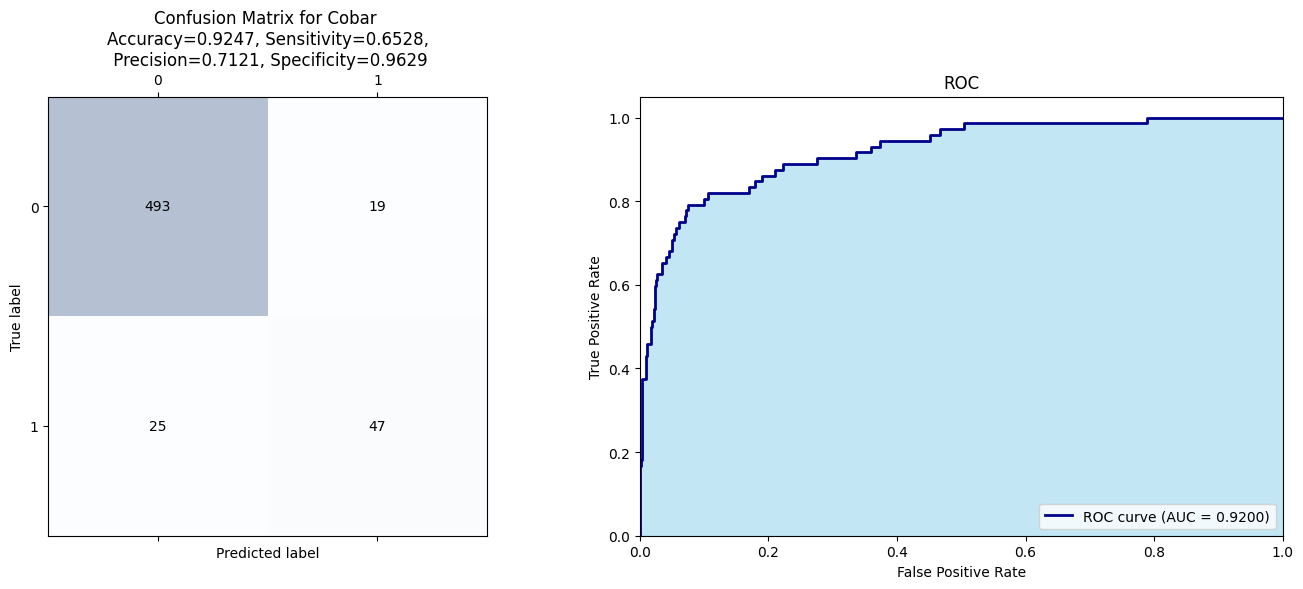

In [265]:
for location in top5_locations:
    print(f"Wyniki modelu dla {location}:")
    test_mask = X_test_prepared['Location'] == location
    X_test_loc = X_test_prepared[test_mask].drop('Location', axis=1)
    y_test_loc = y_test[test_mask]
    plot_metrics_and_roc_adjusted(X_test_loc, y_test_loc, models[location], location)

# Porównaj skuteczność najlepszego modelu ze skutecznością własnej implementacji uczonej na tym samym zbiorze.

In [266]:
encoder = LabelEncoder()

location = top5_locations[0]
train_mask = X_train_prepared['Location'] == location
test_mask = X_test_prepared['Location'] == location

y_train_loc_encoded = encoder.fit_transform(y_train[train_mask])
y_test_loc_encoded = encoder.transform(y_test[test_mask])

X_train_loc = X_train_prepared[train_mask].drop('Location', axis=1).to_numpy()
X_test_loc = X_test_prepared[test_mask].drop('Location', axis=1).to_numpy()

weights = logistic_regression(X_train_loc, y_train_loc_encoded)
y_pred = sigmoid(np.dot(X_test_loc, weights)) > 0.5
accuracy = accuracy_score(y_test_loc_encoded, y_pred)
print(f"Accuracy własnej implementacji regresji logistycznej dla  {location}: {accuracy:.2f}")

Accuracy własnej implementacji regresji logistycznej dla  Uluru: 0.93


Wynik własnej implementacji regresji logistycznej dla Uluru:


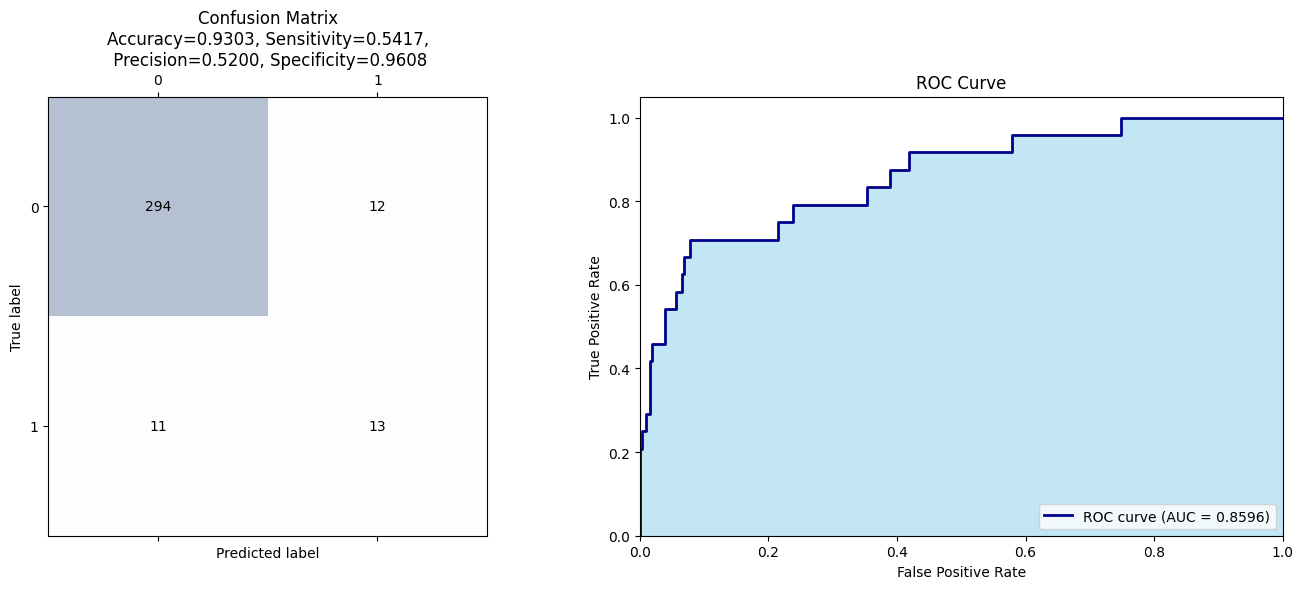

Wynik implementacji LogisticRegression() dla Uluru:


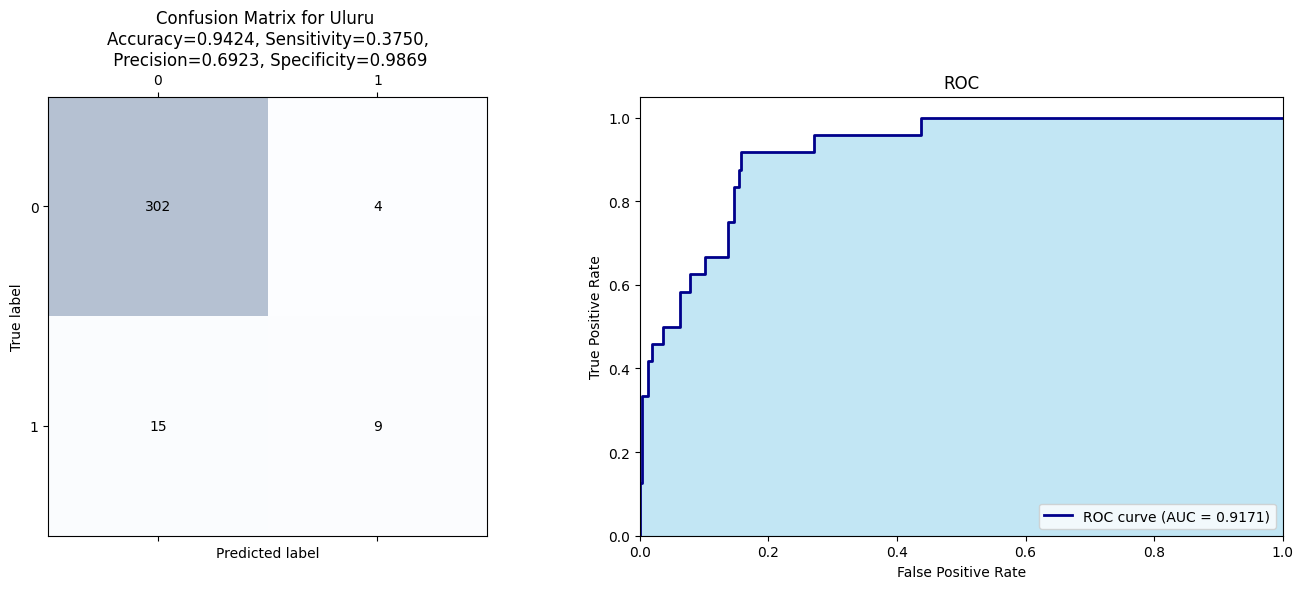

In [267]:
print(f'Wynik własnej implementacji regresji logistycznej dla {location}:')
plot_metrics_and_roc(X_test_loc, y_test_loc_encoded, weights)

y_test_loc = y_test[test_mask]
print(f'Wynik implementacji LogisticRegression() dla {location}:')
plot_metrics_and_roc_adjusted(X_test_loc, y_test_loc, models[location], location)

# Sprawdź skuteczność modeli regionalnych na krajowym zbiorze testowym.

In [268]:
X_test_national = X_test_prepared.drop('Location', axis=1)
y_test_national = y_test

In [269]:
national_accuracies = {}

for location, model in models.items():
    y_pred_national = model.predict(X_test_national)
    accuracy_national = accuracy_score(y_test_national, y_pred_national)
    national_accuracies[location] = accuracy_national
    # print(f"Wynik klasyfikacji modelu regionalnego z {location} na krajowym zbiorze testowym: {accuracy_national:.2f}")

Który model osiągnął najwyższą skuteczność? 

In [270]:
best_location = max(national_accuracies, key=national_accuracies.get)
best_accuracy = national_accuracies[best_location]
print(f"Najwyższą skuteczność osiągnął model z {best_location} z accuracy = {best_accuracy:.2f}.")

Najwyższą skuteczność osiągnął model z Wollongong z accuracy = 0.83.


# Czy był to model o najwyższej skuteczności lokalnej?

In [271]:
print(f"Nie. Model o najwyższej skuteczności lokalnej to model z {best_location_for_regional_prediction}, a model lokalny o najwyższej skuteczności regionalnej jest z {best_location}.")

Nie. Model o najwyższej skuteczności lokalnej to model z Uluru, a model lokalny o najwyższej skuteczności regionalnej jest z Wollongong.


Porównaj skuteczność najlepszego modelu krajowego z `{{sklearn.dummy.DummyClassifier}}`.

In [272]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_prepared, y_train) 
y_dummy_pred = dummy.predict(X_test_national)

dummy_accuracy = accuracy_score(y_test_national, y_dummy_pred)

In [273]:
print(f"Accuracy najepiej radzącego sobie modelu regionalnego: {best_accuracy:.2f}")
print(f"DummyClassifier accuracy: {dummy_accuracy:.2f}")

if best_accuracy > dummy_accuracy:
    print("Model regionalny radzi sobie lepiej niż DummyClassifier().")
else:
    print("DummyClassifier() radzi sobie lepiej niż model regionalny.")

Accuracy najepiej radzącego sobie modelu regionalnego: 0.83
DummyClassifier accuracy: 0.78
Model regionalny radzi sobie lepiej niż DummyClassifier().
